### Feature correlations

This notebook is to assess preliminary models and use heatmaps for feature correlation and lasso regularisation for feature importance.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
import pandas as pd
import os
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv('cleaned_df.csv')
# drop unnamed column
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

In [3]:
X = data.loc[:, ~data.columns.isin(['Name', 'Label'])]
y = data['Label']
X.head()

,Age,BMI,Height,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP.1
0,36.0,34.174890,163,80.0,6.590,1.300427,10.2809,5.065915,15.72187,581.313
1,75.0,30.480000,192,152.0,7.010,2.628283,50.5300,10.060000,11.73000,99.450
2,78.0,25.300000,157,60.0,3.508,0.519184,6.6330,10.567295,4.66380,209.749
3,45.0,21.303949,169,102.0,13.852,3.485163,7.6476,21.056625,23.03408,552.444
4,34.0,24.242424,177,92.0,21.699,4.924226,16.7353,21.823745,12.06534,481.949


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train))
print(len(X_test))
print(len(X))

77
20
97


In [5]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [6]:
# train model
lgr = LogisticRegression()
lgr.fit(X_train, y_train)

# predict test set on model
y_pred_log = lgr.predict(X_test)

# accuracy scores
accu_log = accuracy_score(y_test, y_pred_log) * 100
np.random.seed()
random_guess = np.random.randint(-1, 2, len(y_pred_log))
accu_random_guess = accuracy_score(random_guess, y_pred_log) * 100

print(f'Logistic Regression Model\n \
        Accuracy: {accu_log:.2f}%.\n \
        Random Guess Accuracy: {accu_random_guess:.2f}%')

Logistic Regression Model
         Accuracy: 85.00%.
         Random Guess Accuracy: 10.00%


In [7]:
# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict test set on model
y_pred_lin = np.rint(lr.predict(X_test))

mse_lin = mean_squared_error(y_test, y_pred_lin)
accu_lin = accuracy_score(y_test, y_pred_lin) * 100
r2_lin = r2_score(y_test, y_pred_lin)
np.random.seed()
random_guess = np.random.randint(-1, 2, len(y_pred_log))
accu_random_guess = accuracy_score(random_guess, y_pred_log) * 100
print(f'Linear Regression Model\n \
        Accuracy: {accu_lin:.2f}%.\n \
        MSE: {mse_lin:.2f}\n \
        R2 score: {r2_lin:.2f}\n \
        Random Guess Accuracy: {accu_random_guess:.2f}%')

Linear Regression Model
         Accuracy: 85.00%.
         MSE: 0.15
         R2 score: 0.34
         Random Guess Accuracy: 5.00%


<AxesSubplot:>

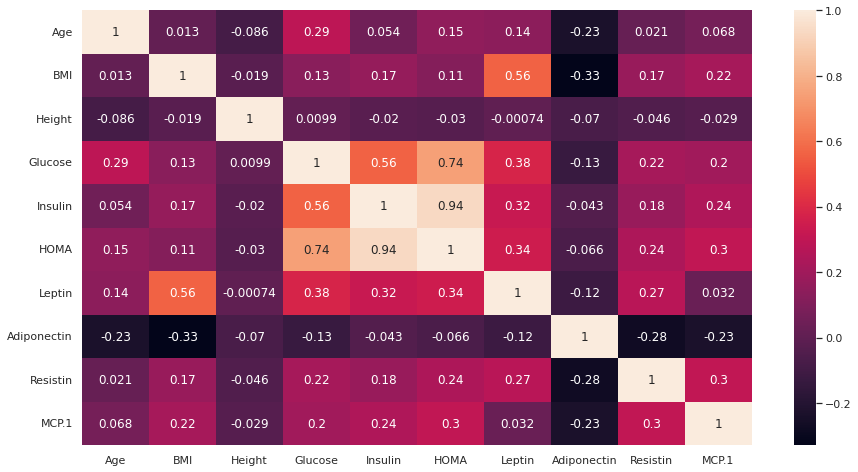

In [8]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(X.corr(), annot=True)

In [11]:
def lasso(X, X_train, y_train):
    
    alphas = [1, 0.5, 0.1]
    lasso_df = pd.DataFrame()
    lasso_df['Feature Name'] = list(X)
    for alpha in alphas:
        lasso = LogisticRegression(C=alpha, penalty='l1', solver='liblinear', random_state=42)
        lasso.fit(X_train, y_train)
        column_name = 'Alpha = %f' % alpha
        lasso_df[column_name] = lasso.coef_[0]
        lasso_df[column_name] = lasso_df[column_name].round(5)
    return lasso_df

lasso_reg = lasso(X, X_train, y_train)

In [12]:
print(lasso_reg.to_markdown())

|    | Feature Name   |   Alpha = 1.000000 |   Alpha = 0.500000 |   Alpha = 0.100000 |
|---:|:---------------|-------------------:|-------------------:|-------------------:|
|  0 | Age            |           -0.35212 |           -0.25864 |            0       |
|  1 | BMI            |           -0.28823 |           -0.18752 |            0       |
|  2 | Height         |            0.0154  |            0       |            0       |
|  3 | Glucose        |            1.57976 |            1.2391  |            0.30405 |
|  4 | Insulin        |            0.2431  |            0.142   |            0       |
|  5 | HOMA           |            0       |            0       |            0       |
|  6 | Leptin         |           -0.20162 |           -0.11711 |            0       |
|  7 | Adiponectin    |            0.26581 |            0.1707  |            0       |
|  8 | Resistin       |            0.44358 |            0.33465 |            0       |
|  9 | MCP.1          |            0.19835 

Glucose seems to show a stronger relevance to a patient having cancer than other features